In [2]:
#a)
import pandas as pd
data = pd.read_csv("compas-scores-two-years.csv")
data = data[data["days_b_screening_arrest"] <= 30]
data = data[data["days_b_screening_arrest"] >= -30]
def prosent(x):
    return round(x*100,1)


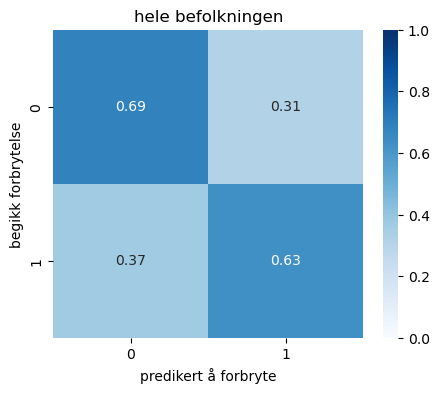

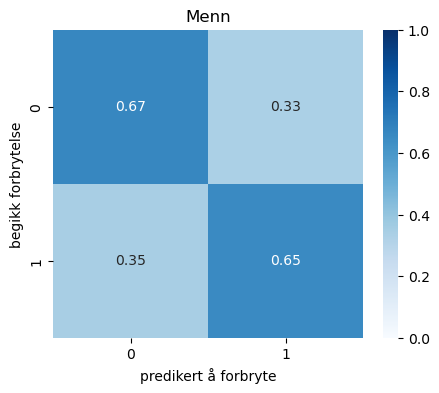

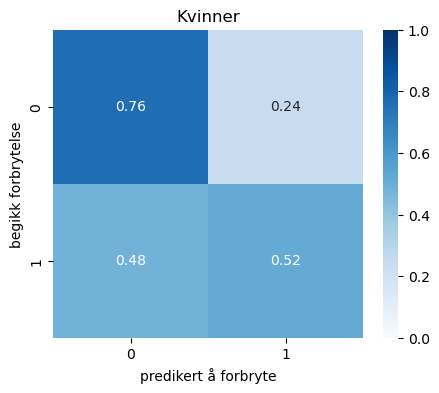

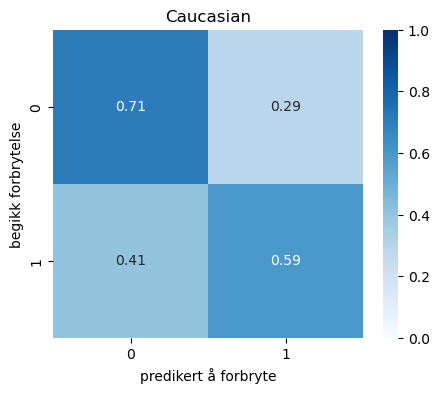

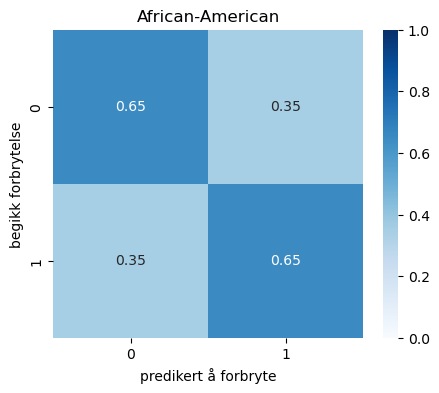

In [3]:
#b)
import seaborn as sns
import matplotlib.pyplot as plt
def finn_sannsynligheter(data):
    #Finner de som ble klassifisert som høy eller lav risiko:
    High_risk = data[data["score_text"].isin(["Medium","High"])]
    Low_risk = data[data["score_text"] == "Low"]

    #Finner hvor bra COMPAS gjorde det:
    Falsk_positiv = High_risk[High_risk["two_year_recid"] == 0]
    Sann_positiv = High_risk[High_risk["two_year_recid"] >= 1]
    Falsk_negativ = Low_risk[Low_risk["two_year_recid"] >= 1]
    Sann_negativ = Low_risk[Low_risk["two_year_recid"] == 0]

    #Finner estimerte sannsynlihgetsverdier:
    p_Falsk_positiv = Falsk_positiv.size/High_risk.size
    p_Sann_positiv = Sann_positiv.size/High_risk.size
    p_Falsk_negativ = Falsk_negativ.size/Low_risk.size
    p_Sann_negativ = Sann_negativ.size/Low_risk.size
    
    
    return p_Falsk_positiv, p_Sann_positiv, p_Falsk_negativ, p_Sann_negativ


def plot_cm(data,title):
    p_Falsk_positiv, p_Sann_positiv, p_Falsk_negativ, p_Sann_negativ = finn_sannsynligheter(data)

    cm = [[p_Sann_negativ,p_Falsk_negativ],[p_Falsk_positiv,p_Sann_positiv]]
    plt.figure(figsize=(5,4))
    sns.heatmap(cm,cmap='Blues',vmin=0,vmax=1,annot=True)
    plt.xlabel("predikert å forbryte")
    plt.ylabel("begikk forbrytelse")
    plt.title(title)

#Finner de forskjellige typene raser:
plot_cm(data,"hele befolkningen")

for kjønn, kjønn_norsk in zip(["Male","Female"],["Menn","Kvinner"]):
    nydata = data[data["sex"] == kjønn]
    plot_cm(nydata,kjønn_norsk)

for rase in ["Caucasian","African-American"]:
    nydata = data[data["race"] == rase]
    plot_cm(nydata,rase)


In [4]:
def p_misklassifisert(key,category,data,keys=None,risk="High"):
    """
    Gir sannsynligheten for at man har blit misklassifisert som høy risiko, 
    gitt at man er i en viss kategori (rase, kjønn, etc)

    f: står for feil
    k: står for at det er den spesifikke kategorien.
    """
    #Finner de som ble klassifisert som høy risiko:
    if keys!=None:
        data = data[data[category].isin(keys)]
    if risk == "High":
        High_risk = data[data["score_text"].isin(["Medium","High"])]
    else:
        High_risk = data[data["score_text"] == "Low"]

    #Finner hvor bra COMPAS gjorde det:
    if risk == "High":
        Falsk_positiv = High_risk[High_risk["two_year_recid"] == 0]
    else:
        Falsk_positiv = High_risk[High_risk["two_year_recid"] != 0]

    #P(misklassifisert):
    p_f=(Falsk_positiv.size)/High_risk.size

    #P(misklassifisert|man er i kategorien)
    p_f_k = (Falsk_positiv[Falsk_positiv[category] == key].size
             /High_risk[High_risk[category] == key].size)
    
    #P(man er i kategorien)
    p_k = High_risk[High_risk[category] == key].size/High_risk.size
    
    #Her bruker jeg bayes setning:
    #P(man er i kategorien| man er misklassifisert)
    p_k_f = (p_f_k*p_k)/p_f

    return p_k_f

print("sannsynlighet for å være afroamerikaner gitt at man er misklassifisert:", prosent(p_misklassifisert("African-American","race",data,["African-American","Caucasian"],risk = "High")),"%")
#print(p_misklassifisert("Caucasian","race",data,["African-American","Caucasian"],risk = "High"))

def p_etnisitet(key,category,data,keys):
    """
    Gir sannsynligheten for å være en gitt etnisitet, gitt at man begår en gjentagende forbrytelse
    """
    if keys!=None:
        data = data[data[category].isin(keys)]
    
    data_etnisitet = data[data[category] == key]
    
    #sannsynlighet for at man gjør en gjentagende forbrytelse:
    p_f = data[data["two_year_recid"] != 0].size/data.size

    #sannsynlighet for at man gjør en gjentagende forbrytelse, gitt at man er i den bestemte kategorien:
    p_f_k = data_etnisitet[data_etnisitet["two_year_recid"] != 0].size/data_etnisitet.size

    #(hvis man plukker en tilfeldig person ut av datasettet) hva er sannsynligheten for at man er i kategorien.
    p_k = data_etnisitet.size/data.size

    #bruker bayes setning til å finne sannsynligheten for å være i kategorien gitt at man gjør en gjentagende forbrytelse
    p_k_f = (p_f_k*p_k)/p_f

    return p_k_f

print("Sannsynlighet for å være afro amerikaner gitt at man har tilbakefall: ",prosent(p_etnisitet("African-American","race",data,["African-American","Caucasian"])),"%")
            

sannsynlighet for å være afroamerikaner gitt at man er misklassifisert: 69.4 %
Sannsynlighet for å være afro amerikaner gitt at man har tilbakefall:  66.9 %


In [ ]:
import sklearn.linear_model as skl
import sklearn.metrics as skm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import  PartialDependenceDisplay

#Setter data som i ProPublica studien:
X_alle_data = data[["age_cat", "race", "sex", "priors_count", "c_charge_degree", "two_year_recid"]]
X_uten_priors = data[["age_cat", "race", "sex", "c_charge_degree", "two_year_recid"]]
X_uten_priors_eller_c_degree = data[["age_cat", "race", "sex", "two_year_recid"]]

#Setter Y data:
Y = data["score_text"] != "Low"

#Definierer sigmoidfunksjonen:
def sigmoid(x):
    return np.where(x>0,1/(1+np.exp(-x)),np.exp(x)/(1+np.exp(x)))

#Jeg definerer tittelene jeg skal bruke:
titteler = ["Alle Data","Uten priors","Uten priors eller charge degree"]

#Her Finner jeg en logistisk modell for alle dataene og når jeg har tatt bort noen data:
for X, i, tittel in zip([X_alle_data,  X_uten_priors,  X_uten_priors_eller_c_degree], range(3), titteler):
    print(tittel+":")
    categorical_cols = ["age_cat", "race", "sex"]
    
    #Jeg tar bort charge degree fra categorical cols når jeg ikke har med den variabelen
    #for å unngå en feilmelding.
    if i!=2:
        categorical_cols+=["c_charge_degree"]
    
    #gjør data om til true/false verdier:
    X = pd.get_dummies(X, columns=categorical_cols, prefix=categorical_cols, prefix_sep='_')
    X = X.drop(["age_cat_25 - 45", "race_Caucasian", "sex_Male"], axis=1)

    #Jeg lar ikke denne koden kjøre når jeg tester uten charge degree for å unngå feilmelding
    if i!=2:
        X = X.drop(["c_charge_degree_F"], axis=1)

    #Lager logistisk modell:
    model = skl.LogisticRegression(max_iter = 1000)
    model.fit(X,Y)

    #Printer nøyaktigheten til modellen:
    print("accuracy of model: ",round(skm.accuracy_score(model.predict(X),Y)*100,1),"%")

    #Finner koeffesienten for hudfarge:
    coef = model.coef_[0][list(X.columns).index("race_African-American")]

    #Finner "standard" verdien:
    b = model.intercept_

    #Finner racial bias til modellen:
    control = sigmoid( b )
    racialBias = np.exp( coef) / (1 - control + (control * np.exp(coef)))
    print("racial bias from logistic model:",round(racialBias[0],2))        
    print()


Alle Data:
accuracy of model:  75.1 %
racial bias from logistic model: 1.45

Uten priors:
accuracy of model:  70.4 %
racial bias from logistic model: 1.63

Uten priors eller charge degree:
accuracy of model:  69.1 %
racial bias from logistic model: 1.71



In [ ]:
for race in ["Caucasian","African-American"]:
    """
    printer bias og nøyaktighet og bias til modellen for hvite og svarte
    """
    #Lager to datasett for om COMPAS trodde noen skulle ha en gjentagende forbrytelse og om de faktisk gjorde det:
    Race_data=data[data["race"] == race]
    Race_y = Race_data["two_year_recid"].apply(lambda x: 1 if x>=1 else 0)
    Race_pred = Race_data["v_score_text"].map({"Low":0,"Medium":1,"High":1})

    #Printer nøyaktigheten til modellen:
    print(race,":\naccuracy: ",round(skm.accuracy_score(Race_pred,Race_y)*100,1),"%")

    #Regner ut bias:
    bias_array = Race_pred.to_numpy()-Race_y.to_numpy()
    bias = np.sum(bias_array)/len(bias_array)
    print("bias: ",round(bias,2))
    
    print()


Caucasian :
accuracy:  63.8 %
bias:  -0.17

African-American :
accuracy:  61.9 %
bias:  -0.09



Alle Data:


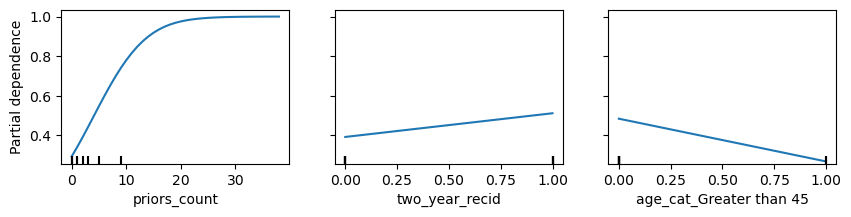

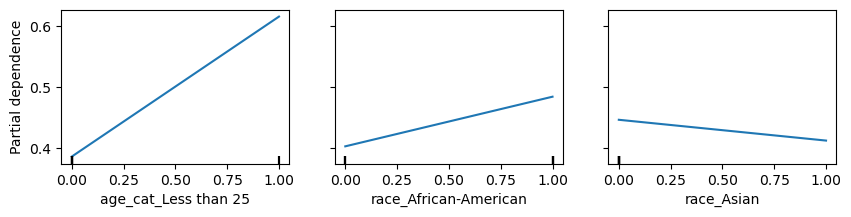

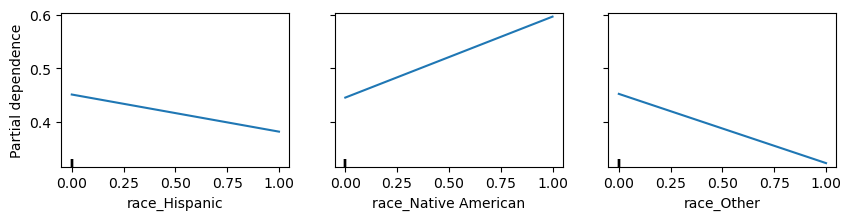

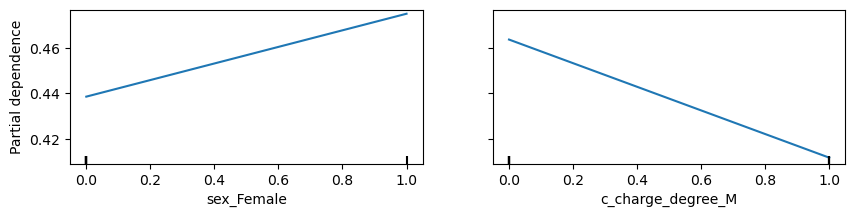


Uten priors:


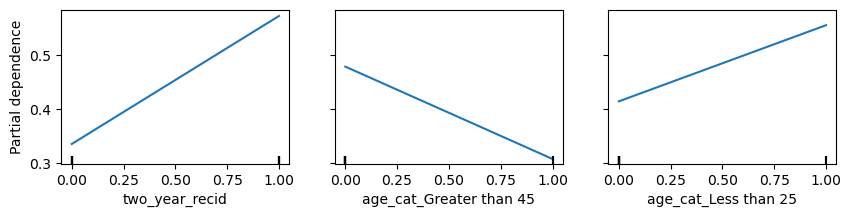

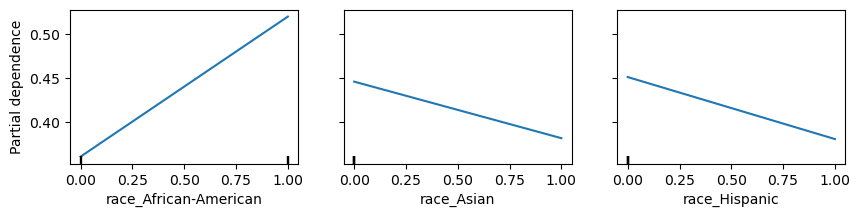

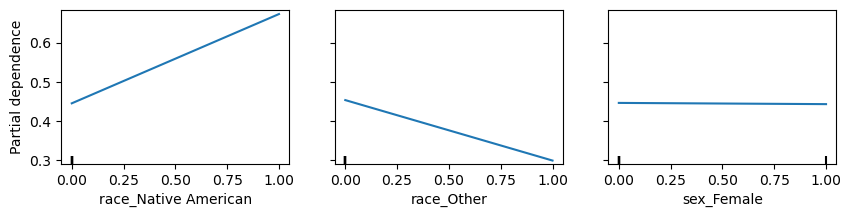

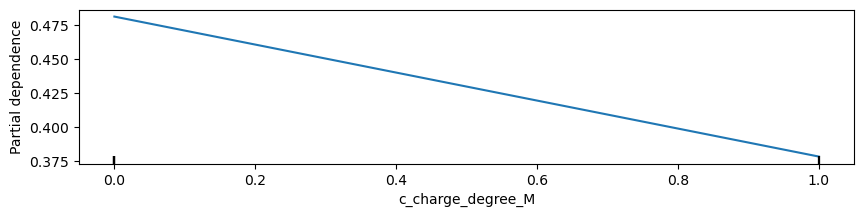


Uten priors eller charge degree:


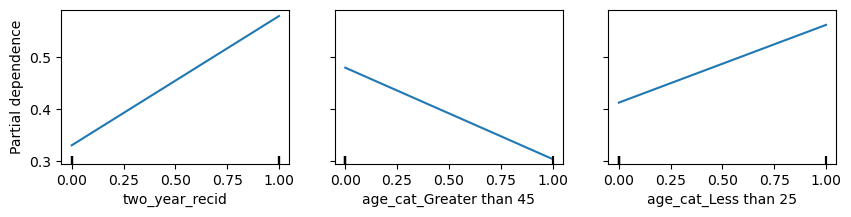

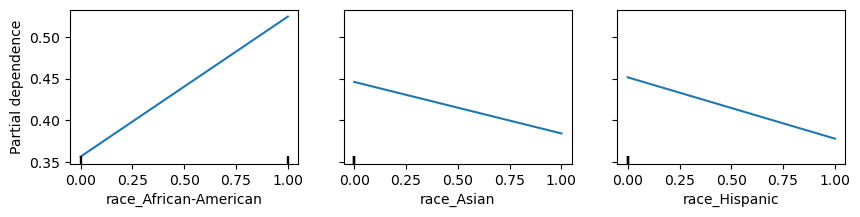

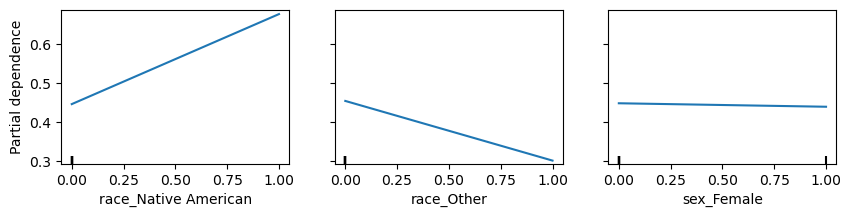

In [ ]:
#Jeg satte koden for plotting av Partial Dependance på bunnen, så man slipper å scrolle forbi den så mye.
for X, i, tittel in zip([X_alle_data,  X_uten_priors,  X_uten_priors_eller_c_degree], range(3),titteler):
    print(tittel+":")
    categorical_cols = ["age_cat", "race", "sex"]
    
    #Jeg tar bort charge degree fra categorical cols når jeg ikke har med den variabelen
    #for å unngå en feilmelding.
    if i!=2:
        categorical_cols+=["c_charge_degree"]
    
    #gjør data om til true/false verdier:
    X = pd.get_dummies(X, columns=categorical_cols, prefix=categorical_cols, prefix_sep='_')
    X = X.drop(["age_cat_25 - 45", "race_Caucasian", "sex_Male"], axis=1)

    #Jeg lar ikke denne koden kjøre når jeg tester uten charge degree for å unngå feilmelding
    if i!=2:
        X = X.drop(["c_charge_degree_F"], axis=1)

    #Lager logistisk modell:
    model = skl.LogisticRegression(max_iter = 1000)
    model.fit(X,Y)

    #Deler opp features inn i mindre grupper, slik at x akse plottene ikke overlapper
    feature_gruppper = [[0, 1, 2],[3, 4, 5],[6, 7, 8]]

    #Siden programmet tester for når man har tatt bort priors, og charge degree,
    #må antall features variere:
    if i==0:
        feature_gruppper+=[[9,10]]
    elif i==1:
        feature_gruppper+=[[9]]

    #Plotter partial depandence:
    for features in feature_gruppper:
        fig, ax = plt.subplots(figsize=(10, 2))
        PartialDependenceDisplay.from_estimator(model, X, features, ax=ax)
        plt.show()
        
    print()
